In [9]:
from IPython.core.display import display, HTML, Image
display(HTML("<style>.container { width:77% !important; }</style>"))

In [10]:
import os
import numpy as np
import pandas as pd
import math

from torch.utils.data import DataLoader, Dataset, TensorDataset
import torchvision.transforms as transforms
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch

########### Вывод изображений и сохранение ################################
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display
from torchvision.utils import save_image, make_grid

In [11]:
plt.rcParams.update({'font.size': 14})
pd.set_option('precision', 3)
pd.set_option('max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('max_colwidth', 300)

In [12]:
use_cuda = torch.cuda.is_available()
# device = torch.device("cpu")
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cpu


In [13]:
x = np.linspace(1, 30, 1000)
def func_y(x):
    return np.sin(x)/x - x/10
print("Func_y:", func_y(x))    

Func_y: [ 7.41470985e-01  7.29725416e-01  7.17782721e-01  7.05647368e-01
  6.93323919e-01  6.80817019e-01  6.68131399e-01  6.55271870e-01
  6.42243322e-01  6.29050718e-01  6.15699096e-01  6.02193562e-01
  5.88539288e-01  5.74741510e-01  5.60805523e-01  5.46736681e-01
  5.32540389e-01  5.18222105e-01  5.03787334e-01  4.89241626e-01
  4.74590569e-01  4.59839793e-01  4.44994959e-01  4.30061761e-01
  4.15045921e-01  3.99953185e-01  3.84789318e-01  3.69560108e-01
  3.54271352e-01  3.38928863e-01  3.23538457e-01  3.08105959e-01
  2.92637193e-01  2.77137979e-01  2.61614135e-01  2.46071467e-01
  2.30515772e-01  2.14952828e-01  1.99388397e-01  1.83828218e-01
  1.68278005e-01  1.52743441e-01  1.37230182e-01  1.21743846e-01
  1.06290013e-01  9.08742229e-02  7.55019713e-02  6.01787064e-02
  4.49098260e-02  2.97006749e-02  1.45565418e-02 -5.17343594e-04
 -1.55158136e-02 -3.04337649e-02 -4.52661620e-02 -6.00080390e-02
 -7.46545032e-02 -8.92007370e-02 -1.03642001e-01 -1.17973635e-01
 -1.32191064e-01 

In [14]:
y = func_y(x)

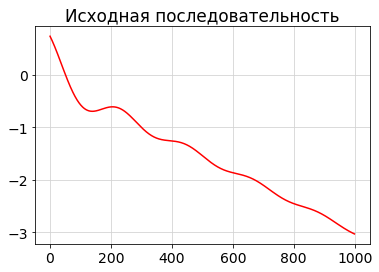

In [15]:
plt.plot(y, 'r')

plt.grid(color="lightgrey")
plt.title('Исходная последовательность' )
plt.show()

In [25]:
class Inc_Dataset(Dataset):
    def __init__(self, b_border, u_border, point_number):
        x = np.linspace(b_border, u_border, point_number)
        if 0 in x:
            x[x == 0] = 0.00001
        self.data = x
        self.labels = np.sin(x)/x - x/10


    def __len__(self):
        return len(self.data) 
    
    
    def __getitem__(self, idx):
        item = self.data[idx]
        label = self.labels[idx]
        return (item, label)

In [26]:
# dataset = y
# dataset = Inc_Dataset(-15, 15, 1001)
dataset = Inc_Dataset(1, 30, 1000)

In [27]:
split_train_part = 0.75
batch_size = 16

real_data_dataset, test_dataset = torch.utils.data.random_split(dataset, 
                                                            [int(split_train_part*dataset.data.shape[0]), 
                                                             dataset.data.shape[0] - int(split_train_part*dataset.data.shape[0])])
real_data_loader = DataLoader(real_data_dataset, batch_size = batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle=False)

In [28]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc4 = nn.Linear(32, 1)
        # self.sigm = nn.Sigmoid()
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        # self.sph = nn.Softplus()

    def forward(self, x):
        # print("X размеры in: %s\n" % (x.shape,))
        x = self.tanh(self.fc1(x))
        # print("X размеры in: %s\n" % (x.shape,))
        x = self.tanh(self.fc2(x))
        # x = self.tanh(self.fc3(x))
        x = self.fc4(x)
        # print("X размеры in: %s\n" % (x.shape,))
        return x

In [29]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1, 128)
        self.fc2 = nn.Linear(128, 128)
        # self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, 1)
        self.sigm = nn.Sigmoid()
        self.tanh = nn.Tanh()
        self.relu = nn.ReLU()
        # self.sfm = nn.Softmax()

    def forward(self, x):
        # print("X размеры d in: %s\n" % (x.shape,))
        x = self.relu(self.fc1(x))
        # print("X размеры fc1 sigm in: %s\n" % (x.shape,))
        x = self.relu(self.fc2(x))
        # x = self.relu(self.fc3(x))
        x = self.sigm(self.fc4(x))
        return x

In [30]:
n_epochs = 1000
lr = 0.0001   # 0.0005

b1 = 0.5
b2 = 0.999

sample_interval = 50

In [31]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))   # torch.optim.SGD(generator.parameters(), lr=lr, momentum=0.9)   # 
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))   # torch.optim.SGD(discriminator.parameters(), lr=lr, momentum=0.9)   # 

adversarial_loss = torch.nn.BCELoss()   # nn.CrossEntropyLoss() 

In [32]:
d_loss_history = []
g_loss_history = []

In [33]:
idx = torch.randperm(16)
idx

tensor([ 9,  6, 13,  5, 12,  1, 14,  2,  0,  3, 10,  4, 15, 11,  8,  7])

In [34]:
for epoch in range(1):
    for i, (number, labels) in enumerate(real_data_loader):

##################### Лейблы для данных: 1 - настоящие, 0 - сгенерированные ########

        valid = Variable(torch.FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False).to(device)
        fake = Variable(torch.FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False).to(device)

        real_number = Variable(number.type(torch.FloatTensor)).to(device)

        #генерация шума
        idx = torch.randperm(batch_size)
        z = Variable(number[idx].type(torch.FloatTensor)).to(device)

        print(f"real_number: {real_number}")
        # print(f"{z.shape}")
        print(f"z: {z.view(16, 1)}")
        print(f"{z.view(16, 1).shape}")
        # print(f"z: {z}")
        # print(f"real_number + z: {real_number + z}")
        print(f"valid.shape: {valid.shape}")
        print(f"fake.shape: {fake.shape}")

        break
    break

real_number: tensor([ 9.4765, 17.9820, 26.7197, 27.4745, 12.9019, 21.9880, 24.9199,  6.4575,
         4.5706, 23.1782, 16.5015, 12.8729, 29.5936, 12.4374, 19.0851, 27.4454])
z: tensor([[27.4454],
        [ 9.4765],
        [12.9019],
        [ 4.5706],
        [17.9820],
        [12.8729],
        [24.9199],
        [23.1782],
        [ 6.4575],
        [16.5015],
        [19.0851],
        [21.9880],
        [26.7197],
        [29.5936],
        [12.4374],
        [27.4745]])
torch.Size([16, 1])
valid.shape: torch.Size([16, 1])
fake.shape: torch.Size([16, 1])


In [36]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cpu


[Epoch 498/500] [Batch 44/47] [D loss: 0.679002] [G loss: 0.711494]


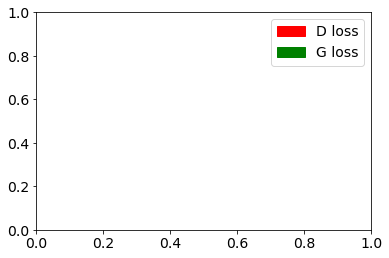

In [39]:
import matplotlib.patches as mpatches

red_patch = mpatches.Patch(color='red', label='D loss')
green_patch = mpatches.Patch(color='green', label='G loss')

g_loss_p = 1000
ep_loss = 0
n_epochs = 500

for epoch in range(n_epochs):
    for i, (number, labels) in enumerate(real_data_loader):

##################### Лейблы для данных: 1 - настоящие, 0 - сгенерированные ########

        valid = Variable(torch.FloatTensor(len(number), 1).fill_(1.0), requires_grad=False).to(device)
        fake = Variable(torch.FloatTensor(len(labels), 1).fill_(0.0), requires_grad=False).to(device)

        real_numbers = Variable(number.type(torch.FloatTensor)).to(device)

######################  Тренировка генератора    ##########################

        optimizer_G.zero_grad()
    
        #генерация шума
        idx = torch.randperm(len(number))
        z = Variable(number[idx].type(torch.FloatTensor)).to(device)

        gen_numbers = generator(z.view(len(z), 1))

        validity = discriminator(gen_numbers)
        g_loss = adversarial_loss(validity, valid)
        
        g_loss.backward()
        optimizer_G.step()

        if g_loss < g_loss_p:
            torch.save(generator.state_dict(), "series_gan_loss_min.pth")
            g_loss_p = g_loss
            ep_loss = epoch

######################  Тренировка дискриминатора    ##########################

        optimizer_D.zero_grad()

        real_pred = discriminator(labels.view(len(labels), 1).type(torch.FloatTensor).to(device))
        d_real_loss = adversarial_loss(real_pred, valid)

        fake_pred = discriminator(gen_numbers.detach())
        d_fake_loss = adversarial_loss(fake_pred, fake)

        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()
        
######## Отображение процесса обучения и вывод функций потерь ############

        batches_done = epoch * len(real_data_loader) + i
    
        if batches_done % sample_interval == 0:
            plt.clf()
            
            display.clear_output(wait=False)
            # sample_image(gen_imgs)
            print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"% (epoch, n_epochs, i, len(real_data_loader), d_loss.item(), g_loss.item()) ) 
            
            # display.display(plt.gcf())

            d_loss_history.append(d_loss)
            g_loss_history.append(g_loss)

#             plt.plot(np.log(np.array(d_loss_history)), label='D loss', color = 'red')
#             plt.plot(np.log(np.array(g_loss_history)), label='G loss', color = 'green')
            plt.legend(handles=[red_patch, green_patch])
            plt.show()